<h1>IBM Data Science Final Project</h1>

<h2>Introduction: Business Problem</h2>

<b>One of my friends , Robinson, is relocating to India and is interested in setting up an Italian Restaurant in Chennai.He has been a Pizza lover since his childhood. He doesn't want to setup a pizza alone store. He is looking at locations where presence of Italian flavour is minimal. He has asked me to leverage my data science skills and come up with ideal locations for his new venture i.e. Italian Restaurant.</b>

<h3>Data</h3>

<b> Based on my friend's requirements, below are the factors that needs to be considered</b>
1. Number of existing restaurants in each neighburhood
2. Number of Italian restaurants in each neighborhood
3. Proximity and distance

<b>To achieve the above:</b>
1. First we need to get the list of neighborhoods in Chennai city
https://en.wikipedia.org/wiki/Category:Suburbs_of_Chennai
2. We need to scrape the wikipedia page containing the neighborhoods details ans fetch them
3. Then for each neighborhood, get latitude and longitude using Google Maps API
4. Then, using the four square API,get the restaurants and Italian Restaurant in each neighborhood
5. We will then use k-means clustering method to group the neighborhoods based on how similar they are.
6. The tools for EDA will be pandas, folium, google API, matplotlib.


In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import json
!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim 
import requests
from pandas.io.json import json_normalize
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
!conda install -c conda-forge folium=0.5.0 --yes
import folium
print('Libraries imported.')

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.

Libraries imported.


In [2]:
import matplotlib.pyplot as plt

<b>Scrape data from wikipedia page to get the neighborhoods</b>

In [3]:
data = requests.get("https://en.wikipedia.org/wiki/Category:Suburbs_of_Chennai").text

In [4]:
from bs4 import BeautifulSoup

<b>Using lxml Parser, parse the contents of the data using BeautifulSoup library</b>

In [5]:
soup=BeautifulSoup(data,'lxml')

<b>Traverse through all the list elements under the class mw_category and add all the neighborhoods to a list</b>

In [6]:
neighborhood=[]
for row in soup.find_all("div", class_="mw-category")[0].findAll("li"):
    neighborhood.append(row.text)
neighborhood

['Alandur',
 'Anna Nagar',
 'Ashok Nagar, Chennai',
 'Assisi Nagar',
 'Ayanavaram',
 'Chennai city',
 'Chitlapakkam',
 'Chromepet',
 'Cowl Bazaar',
 'Egattur (Kanchipuram District)',
 'Iyyapanthangal',
 'K. K. Nagar, Chennai',
 'Kallikuppam, Ambattur',
 'Kamarajapuram',
 'Keelkattalai',
 'Kelambakkam',
 'Kilpauk',
 'Kodambakkam',
 'Kodungaiyur',
 'Kolathur, Chennai',
 'Korattur',
 'Korukkupet',
 'Kosappur',
 'Madhavaram Milk Colony',
 'Madipakkam',
 'Maduravoyal',
 'Manali New Town',
 'Manapakkam',
 'Mannivakkam',
 'Mugalivakkam',
 'Nagappa Nagar',
 'Navalur',
 'Nazarethpettai',
 'Oragadam',
 'Padappai',
 'Pallavaram',
 'Pallikaranai',
 'Panambakkam',
 'Pattabiram',
 'Perambakkam',
 'Polichalur',
 'Poonamallee',
 'Potheri village, Kanchipuram',
 'Pudupakkam',
 'Pudur, Ambattur',
 'Puzhal',
 'Saidapet',
 'Selaiyur',
 'Semmencherry',
 'Senji, Chennai',
 'Sholinganallur',
 'Singaperumalkoil',
 'Sriperumbudur',
 'Tambaram',
 'Thalambur',
 'Thuraipakkam',
 'Vadapalani',
 'Virugambakkam',
 '

<b>Create a function that returns the latitude and longitude of a given address</b>

In [7]:
def get_lat_long(neighborhood):
    geolocator = Nominatim(user_agent="manoj483@gmail.com")
    latitude=None
    longitude=None
    location = geolocator.geocode(neighborhood,timeout=25)
    if location is not None:
        latitude = location.latitude
        longitude = location.longitude
    return latitude, longitude


<b>For each neighborhood in the list, get the latitude and longitude and add to a dataframe. If the latitude or longitude values are NaN, delete them.</b>

In [8]:
address_geocode_list=[]
for address in neighborhood:
    latitude, longitude = get_lat_long(address)
    address_geocode_list.append([address,latitude,longitude])
#address_geocode_list
df_geo_list = pd.DataFrame(address_geocode_list,columns=['Neighborhood','Latitude','Longitude'])
df_geo_list = df_geo_list.dropna()
df_geo_list.head()
    

,Neighborhood,Latitude,Longitude
0,Alandur,12.994373,80.194284
1,Anna Nagar,11.170349,77.351114
2,"Ashok Nagar, Chennai",13.040073,80.215925
3,Assisi Nagar,13.164610,80.233000
4,Ayanavaram,13.094616,80.235410


<b>Get latitude and longitude of Chennai</b>

In [9]:
latitude, longitude = get_lat_long('Chennai')
print ('Latitude and Longitude of Chennai is {},{}'.format(latitude,longitude))

Latitude and Longitude of Chennai is 13.0801721,80.2838331


<b>Create a map of Chennai with neighborhoods superimposed on it</b>

In [10]:
chennai_map = folium.Map(location=[latitude, longitude], zoom_start=10)

for latitude, longitude, neighborhood in zip(df_geo_list['Latitude'], df_geo_list['Longitude'], df_geo_list['Neighborhood']):
    name = '{}'.format(neighborhood)
    name = folium.Popup(name, parse_html=True)
    folium.CircleMarker(
        [latitude, longitude],
        radius=5,
        popup=name,
        color='Green',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(chennai_map)  
    
chennai_map

In [11]:
def Is_Rest(categoryname):
    is_rest=False
    rest_category = ['Restaurant', 'Pizza']
    for category in rest_category:       
        if category in categoryname:
            is_rest = True        
    return is_rest  

In [12]:
def Is_Italian(rest_name):
    is_italian=False
    Italian_names = ['Pizza', 'Italian', 'Pasta']
    for name in Italian_names:     
        if (name in rest_name):            
            is_italian = True        
    return is_italian

In [13]:
food_category = '4d4b7105d754a06374d81259'
client_id = '3EOWOXC2GALRBU3XZVFAIDXYFA05DFEGQZTINXMP0UZAXYPA'
client_secret = '2MESB5C1MFB4Y414G3O44BWVA2V2YKOLNG0QECUWASAQXAD1'
venues=[]
version = '20180724'
#def get_venues(client_id, client_secret, radius=750, limit=300):
    
for neighborhood, latitude, longitude in zip(df_geo_list['Neighborhood'],df_geo_list['Latitude'], df_geo_list['Longitude']):
        
        url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&CategoryId={}&ll={},{}&radius={}&limit={}'.format(
        client_id, client_secret, version,food_category, latitude, longitude, 1000, 100)
        results = requests.get(url).json()['response']['groups'][0]['items']
        for venue in results:
            venues.append((
            neighborhood,
            latitude, 
            longitude, 
            venue['venue']['name'], 
            venue['venue']['location']['lat'], 
            venue['venue']['location']['lng'],  
            venue['venue']['categories'][0]['name'],
            Is_Rest(venue['venue']['categories'][0]['name']),
            Is_Italian(venue['venue']['name'])
            ))


In [14]:
df_venue = pd.DataFrame(venues)
df_venue.columns = ['Neighborhood', 'Latitude', 'Longitude', 'Venue_Name', 'Venue_Latitude', 'Venue_Longitude', 'Venue_Category', 'Is_Resturant','Is_Italian']
df_venue = df_venue[df_venue.Is_Resturant == True].reset_index(drop=True)
df_venue.head()

,Neighborhood,Latitude,Longitude,Venue_Name,Venue_Latitude,Venue_Longitude,Venue_Category,Is_Resturant,Is_Italian
0,Alandur,12.994373,80.194284,Pizza Republic,12.990987,80.198613,Pizza Place,True,True
1,Alandur,12.994373,80.194284,Hotel Saravana Bhavan,12.996520,80.190224,South Indian Restaurant,True,False
2,Alandur,12.994373,80.194284,Sukkkubai Beef Biryani Shop,12.998769,80.201381,Indian Restaurant,True,False
3,Alandur,12.994373,80.194284,The Great Kebab Factory,12.994200,80.187495,Indian Restaurant,True,False
4,Alandur,12.994373,80.194284,Aasife & Brothers Biryani Centre,13.000457,80.200635,Indian Restaurant,True,False


In [15]:
print('Total Restaurants in Chennai under given conditions:',df_venue.Is_Resturant.count())
print ('Total Italian Restaurants in Chennai under given conditions:', df_venue[df_venue.Is_Italian==True].Is_Italian.count())

Total Restaurants in Chennai under given conditions: 161
Total Italian Restaurants in Chennai under given conditions: 28


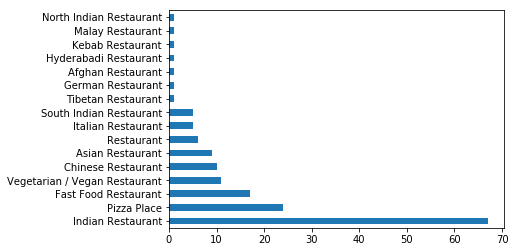

In [16]:
df_venue['Venue_Category'].value_counts().plot(kind='barh')

In [17]:
df_venue_onehot = pd.get_dummies(df_venue[['Venue_Category']], prefix="", prefix_sep="")
df_venue_onehot['Neighborhood'] = df_venue['Neighborhood'] 
df_venue_onehot
cols_reorder = [df_venue_onehot.columns[-1]] + list(df_venue_onehot.columns[:-1])
df_venue_onehot = df_venue_onehot[cols_reorder]
df_venue_onehot = df_venue_onehot[['Neighborhood', 'Italian Restaurant', 'Chinese Restaurant', 'South Indian Restaurant', 'Indian Restaurant']]
df_venue_onehot.head()

,Neighborhood,Italian Restaurant,Chinese Restaurant,South Indian Restaurant,Indian Restaurant
0,Alandur,0,0,0,0
1,Alandur,0,0,1,0
2,Alandur,0,0,0,1
3,Alandur,0,0,0,1
4,Alandur,0,0,0,1


In [18]:
neighborhood_group = df_venue_onehot.groupby('Neighborhood').mean().reset_index()

In [19]:
for address in neighborhood_group['Neighborhood']:
        temp = neighborhood_group[neighborhood_group['Neighborhood'] == address].T.reset_index()
        temp.columns=['Venue', 'Occurance']
        temp = temp.iloc[1:]        
        temp['Occurance'] = temp['Occurance'].astype(float)
        temp = temp.round({'Occurance': 2})        

In [20]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [21]:
num_top_venues = 4

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = neighborhood_group['Neighborhood']

for ind in np.arange(neighborhood_group.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(neighborhood_group.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue
0,Alandur,Indian Restaurant,South Indian Restaurant,Chinese Restaurant,Italian Restaurant
1,"Ashok Nagar, Chennai",Indian Restaurant,Chinese Restaurant,South Indian Restaurant,Italian Restaurant
2,Assisi Nagar,Indian Restaurant,South Indian Restaurant,Chinese Restaurant,Italian Restaurant
3,Chromepet,Indian Restaurant,South Indian Restaurant,Chinese Restaurant,Italian Restaurant
4,Iyyapanthangal,Indian Restaurant,South Indian Restaurant,Chinese Restaurant,Italian Restaurant
5,Keelkattalai,Indian Restaurant,South Indian Restaurant,Chinese Restaurant,Italian Restaurant
6,Kelambakkam,Indian Restaurant,South Indian Restaurant,Chinese Restaurant,Italian Restaurant
7,Kilpauk,Indian Restaurant,South Indian Restaurant,Chinese Restaurant,Italian Restaurant
8,Kodambakkam,Indian Restaurant,Chinese Restaurant,South Indian Restaurant,Italian Restaurant
9,"Kolathur, Chennai",Indian Restaurant,South Indian Restaurant,Chinese Restaurant,Italian Restaurant


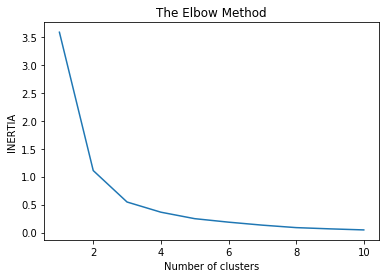

In [22]:
chennai_cluster = neighborhood_group.drop('Neighborhood', 1)
inertia=[]
for i in range(1, 11):
    km = KMeans(n_clusters=i)
    km = km.fit(chennai_cluster)
    inertia.append(km.inertia_)
plt.plot(range(1, 11), inertia)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('INERTIA')
plt.show()

In [23]:
kclusters=3
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(chennai_cluster)
kmeans.labels_

array([2, 2, 1, 2, 2, 2, 1, 1, 2, 1, 0, 2, 0, 2, 2, 2, 1, 2, 0, 1, 2, 0,
       1, 2, 2, 2, 0, 2, 2, 0], dtype=int32)

In [24]:
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
chennai_merged = df_venue
chennai_merged = chennai_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
chennai_merged.head()

,Neighborhood,Latitude,Longitude,Venue_Name,Venue_Latitude,Venue_Longitude,Venue_Category,Is_Resturant,Is_Italian,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue
0,Alandur,12.994373,80.194284,Pizza Republic,12.990987,80.198613,Pizza Place,True,True,2,Indian Restaurant,South Indian Restaurant,Chinese Restaurant,Italian Restaurant
1,Alandur,12.994373,80.194284,Hotel Saravana Bhavan,12.996520,80.190224,South Indian Restaurant,True,False,2,Indian Restaurant,South Indian Restaurant,Chinese Restaurant,Italian Restaurant
2,Alandur,12.994373,80.194284,Sukkkubai Beef Biryani Shop,12.998769,80.201381,Indian Restaurant,True,False,2,Indian Restaurant,South Indian Restaurant,Chinese Restaurant,Italian Restaurant
3,Alandur,12.994373,80.194284,The Great Kebab Factory,12.994200,80.187495,Indian Restaurant,True,False,2,Indian Restaurant,South Indian Restaurant,Chinese Restaurant,Italian Restaurant
4,Alandur,12.994373,80.194284,Aasife & Brothers Biryani Centre,13.000457,80.200635,Indian Restaurant,True,False,2,Indian Restaurant,South Indian Restaurant,Chinese Restaurant,Italian Restaurant


In [25]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(chennai_merged['Latitude'], chennai_merged['Longitude'], chennai_merged['Neighborhood'], chennai_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [26]:
chennai_merged.loc[chennai_merged['Cluster Labels'] == 0, chennai_merged.columns[[1] + list(range(5, chennai_merged.shape[1]))]]

,Latitude,Venue_Longitude,Venue_Category,Is_Resturant,Is_Italian,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue
55,13.111539,80.186400,Pizza Place,True,True,0,Indian Restaurant,South Indian Restaurant,Chinese Restaurant,Italian Restaurant
59,32.245461,77.187490,Italian Restaurant,True,False,0,Italian Restaurant,Indian Restaurant,South Indian Restaurant,Chinese Restaurant
60,32.245461,77.189424,Tibetan Restaurant,True,False,0,Italian Restaurant,Indian Restaurant,South Indian Restaurant,Chinese Restaurant
61,32.245461,77.189333,Asian Restaurant,True,False,0,Italian Restaurant,Indian Restaurant,South Indian Restaurant,Chinese Restaurant
62,32.245461,77.189406,German Restaurant,True,False,0,Italian Restaurant,Indian Restaurant,South Indian Restaurant,Chinese Restaurant
63,32.245461,77.189738,Asian Restaurant,True,False,0,Italian Restaurant,Indian Restaurant,South Indian Restaurant,Chinese Restaurant
64,32.245461,77.188165,Restaurant,True,False,0,Italian Restaurant,Indian Restaurant,South Indian Restaurant,Chinese Restaurant
89,13.037807,79.809105,Asian Restaurant,True,False,0,Indian Restaurant,South Indian Restaurant,Chinese Restaurant,Italian Restaurant
100,12.893536,80.228000,Pizza Place,True,True,0,Indian Restaurant,South Indian Restaurant,Chinese Restaurant,Italian Restaurant
101,12.893536,80.228689,Restaurant,True,False,0,Indian Restaurant,South Indian Restaurant,Chinese Restaurant,Italian Restaurant


In [27]:
chennai_merged.loc[chennai_merged['Cluster Labels'] == 1, chennai_merged.columns[[1] + list(range(5, chennai_merged.shape[1]))]]

,Latitude,Venue_Longitude,Venue_Category,Is_Resturant,Is_Italian,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue
31,13.164610,80.227178,Indian Restaurant,True,False,1,Indian Restaurant,South Indian Restaurant,Chinese Restaurant,Italian Restaurant
44,12.787144,80.221095,Indian Restaurant,True,False,1,Indian Restaurant,South Indian Restaurant,Chinese Restaurant,Italian Restaurant
45,13.083215,80.240191,Fast Food Restaurant,True,False,1,Indian Restaurant,South Indian Restaurant,Chinese Restaurant,Italian Restaurant
46,13.083215,80.238691,Indian Restaurant,True,False,1,Indian Restaurant,South Indian Restaurant,Chinese Restaurant,Italian Restaurant
47,13.083215,80.239296,Indian Restaurant,True,False,1,Indian Restaurant,South Indian Restaurant,Chinese Restaurant,Italian Restaurant
48,13.083215,80.245111,Indian Restaurant,True,False,1,Indian Restaurant,South Indian Restaurant,Chinese Restaurant,Italian Restaurant
53,13.124113,80.203467,Indian Restaurant,True,False,1,Indian Restaurant,South Indian Restaurant,Chinese Restaurant,Italian Restaurant
54,13.124113,80.201248,Indian Restaurant,True,False,1,Indian Restaurant,South Indian Restaurant,Chinese Restaurant,Italian Restaurant
81,12.887693,80.030190,Indian Restaurant,True,False,1,Indian Restaurant,South Indian Restaurant,Chinese Restaurant,Italian Restaurant
90,12.818326,80.040739,Indian Restaurant,True,False,1,Indian Restaurant,South Indian Restaurant,Chinese Restaurant,Italian Restaurant


In [28]:
chennai_merged.loc[chennai_merged['Cluster Labels'] == 2, chennai_merged.columns[[1] + list(range(5, chennai_merged.shape[1]))]]

,Latitude,Venue_Longitude,Venue_Category,Is_Resturant,Is_Italian,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue
0,12.994373,80.198613,Pizza Place,True,True,2,Indian Restaurant,South Indian Restaurant,Chinese Restaurant,Italian Restaurant
1,12.994373,80.190224,South Indian Restaurant,True,False,2,Indian Restaurant,South Indian Restaurant,Chinese Restaurant,Italian Restaurant
2,12.994373,80.201381,Indian Restaurant,True,False,2,Indian Restaurant,South Indian Restaurant,Chinese Restaurant,Italian Restaurant
3,12.994373,80.187495,Indian Restaurant,True,False,2,Indian Restaurant,South Indian Restaurant,Chinese Restaurant,Italian Restaurant
4,12.994373,80.200635,Indian Restaurant,True,False,2,Indian Restaurant,South Indian Restaurant,Chinese Restaurant,Italian Restaurant
5,12.994373,80.198967,Indian Restaurant,True,False,2,Indian Restaurant,South Indian Restaurant,Chinese Restaurant,Italian Restaurant
6,12.994373,80.198461,Pizza Place,True,True,2,Indian Restaurant,South Indian Restaurant,Chinese Restaurant,Italian Restaurant
7,12.994373,80.199085,Indian Restaurant,True,False,2,Indian Restaurant,South Indian Restaurant,Chinese Restaurant,Italian Restaurant
8,12.994373,80.191351,Chinese Restaurant,True,False,2,Indian Restaurant,South Indian Restaurant,Chinese Restaurant,Italian Restaurant
9,12.994373,80.198937,Asian Restaurant,True,False,2,Indian Restaurant,South Indian Restaurant,Chinese Restaurant,Italian Restaurant


<b> From the above clusters, though the solution is not clear, cluster 3 doesn't have a presence of authentic Italian Restaurant. This can be looked upon as a possible locations to start a new Italian Restaurant</b>